In [3]:
from datasets import load_dataset, get_dataset_split_names, Image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from ultralytics import YOLO

from tqdm import tqdm

/home/chateaux/OpenClassrooms/Projet8/veille technique/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Inspect dataset splits
get_dataset_split_names("benjamintli/SKU110k")

['train', 'validation', 'test']

In [ ]:
dataset = load_dataset("benjamintli/SKU110k")
# dataset = dataset.cast_column("image", Image())

In [ ]:
print(dataset['train'])

Dataset({
    features: ['image', 'objects'],
    num_rows: 8219
})


In [ ]:
sample = dataset["train"][0] 
print(type(sample["image"]))  # PIL.Image.Image
print(sample["objects"].keys())

<class 'PIL.JpegImagePlugin.JpegImageFile'>
dict_keys(['bbox', 'category'])


In [ ]:
sample["objects"]['bbox'][0]

[208.0, 537.0, 214.0, 277.0]

Note : ne fonctionne que si pillow est installé, si ce n'était pas le cas, il faut réinitialiser l'environnement, lui ajouter pillow et relancer tout le notebook

### Vérification visuelle du format des bbox

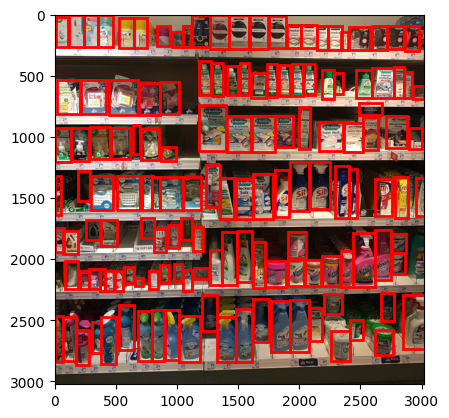

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(sample["image"])

for bbox in sample["objects"]['bbox']:

    x, y, w, h = bbox
    rect = patches.Rectangle(
        (x, y), w, h,
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)

plt.show()


Les bbox sont bien au format coco : [x_min, y_min, width, height]

# Enregistrer les données au format YOLO

In [ ]:
type(dataset['train'][0]['image'])

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
import os

def convert_input_to_yolo(dataset, output_dir):
    """
    Method that transforms all bbox from benjamintli/SKU110k input data to yolo format so that 
    it can be used as input to a YOLO model. It then saves the data in the proper YOLO architecture.
    """
    for split in dataset.keys():
        output_image_dir = f"{output_dir}/images/{split}/"
        if not os.path.isdir(output_image_dir):
            os.makedirs(output_image_dir)
        output_labels_dir = f"{output_dir}/labels/{split}/"
        if not os.path.isdir(output_labels_dir):
            os.makedirs(output_labels_dir)
        for idx_im, image in enumerate(tqdm(dataset[split], desc = f"{split} split")):
            im_width, im_height = image['image'].size
            image['image'].save(os.path.join(output_image_dir, f"image_{idx_im}.jpeg"))
            output_label_file = os.path.join(output_labels_dir, f"image_{idx_im}.txt")
            with open(output_label_file, 'w') as f:
                for idx_box, bbox in enumerate(image['objects']['bbox']):
                    category_id = image['objects']['category'][idx_box]
                    #transform and normalize
                    x_min, y_min, width, height = bbox
                    x_center = (x_min + width / 2) / im_width
                    y_center = (y_min + height / 2) / im_height
                    width /= im_width
                    height /= im_height
                    f.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

In [ ]:
convert_input_to_yolo(dataset, 'SKU110k')

test split: 100%|██████████| 2936/2936 [02:08<00:00, 22.87it/s]


### Vérification visuelle de la transformation en YOLO

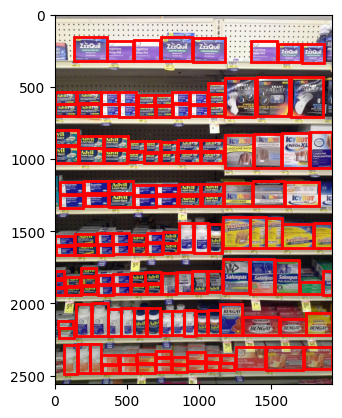

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

img = Image.open("SKU110k/images/test/image_3.jpeg")
w, h = img.size
fig, ax = plt.subplots(1)
ax.imshow(img)

# lines_list = []
with open("SKU110k/labels/test/image_3.txt") as f:
    lines_list = [line.rstrip('\n').split() for line in f]

for line in lines_list: 
    cls, cx, cy, bw, bh = map(float, line)
    x = (cx - bw / 2) * w
    y = (cy - bh / 2) * h
    bw *= w
    bh *= h
    ax.add_patch(
        patches.Rectangle((x, y), bw, bh, edgecolor="red", facecolor="none", linewidth=2)
    )
plt.show()


Les rectangles encadrent bien les produits, la conversion est correcte.

In [36]:
model = YOLO("yolov3-tinyu.pt")

In [37]:
# Display model information (optional)
model.info()

YOLOv3-tiny summary: 53 layers, 12,173,248 parameters, 0 gradients, 19.1 GFLOPs


(53, 12173248, 0, 19.125708799999998)

In [38]:
len(list(model.named_parameters())) #nombre de paramètres, il peut y avoir plusieurs paramètres par couches

66

In [39]:
len(model.model.model)#blocs yolo principaux, liste gérée par freeze

21

In [49]:
dir(model.model.model.__class__)

['T_destination',
 '__add__',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_compiled_call_impl',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_item_by_idx',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 '_wrapped_call

In [50]:
for i, layer in enumerate(model.model.model):
    print(i, layer.__class__.__name__)

0 Conv
1 MaxPool2d
2 Conv
3 MaxPool2d
4 Conv
5 MaxPool2d
6 Conv
7 MaxPool2d
8 Conv
9 MaxPool2d
10 Conv
11 ZeroPad2d
12 MaxPool2d
13 Conv
14 Conv
15 Conv
16 Conv
17 Upsample
18 Concat
19 Conv
20 Detect


In [ ]:
# Fine tuning de la dernière couche de détection (Detect)
results = model.train(data="dataset_config.yaml", device=-1, freeze = len(model.model.model) -1, epochs = 50, batch = 4)

New https://pypi.org/project/ultralytics/8.4.12 available 😃 Update with 'pip install -U ultralytics'
Searching for 1 idle GPUs with free memory >= 20.0% and free utilization >= 0.0%...
Selected idle CUDA devices [0]
Ultralytics 8.4.9 🚀 Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_config.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=20, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_rati

In [56]:
metrics = model.val(data="dataset_config.yaml", split="test")

Ultralytics 8.4.9 🚀 Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLOv3-tiny summary (fused): 34 layers, 12,128,178 parameters, 0 gradients, 18.9 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 369.7±188.9 MB/s, size: 948.1 KB)
val: Scanning /home/chateaux/OpenClassrooms/Projet8/veille technique/SKU110k/labels/test.cache... 2936 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2936/2936 456.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 184/184 5.0it/s 36.8s0.1ss
                   all       2936     431546      0.868      0.761      0.843       0.49
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /home/chateaux/OpenClassrooms/Projet8/veille technique/runs/detect/val8


Ajouter la visualisation des boites de détection + résultats de métriques

In [61]:
# Run batched inference on a list of images
results = model("SKU110k/images/test/image_3.jpeg")  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk


image 1/1 /home/chateaux/OpenClassrooms/Projet8/veille technique/SKU110k/images/test/image_3.jpeg: 640x480 183 objects, 233.4ms
Speed: 31.3ms preprocess, 233.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 480)


# RF DTR

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


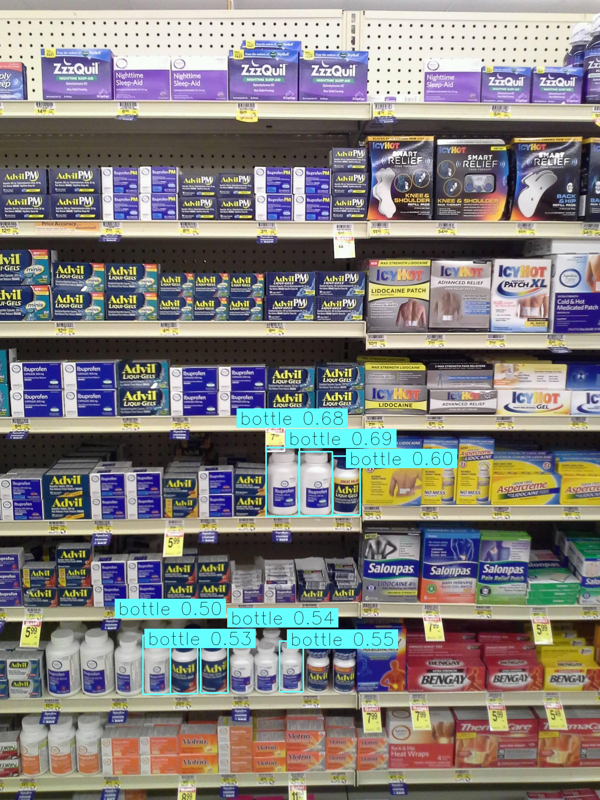

In [62]:
import numpy as np
import supervision as sv

from PIL import Image

from rfdetr import RFDETRMedium
from rfdetr.util.coco_classes import COCO_CLASSES

image = Image.open("SKU110k/images/test/image_3.jpeg")

model = RFDETRMedium(resolution=640)
model.optimize_for_inference()

detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image.thumbnail((800, 800))
annotated_image

## Fine tune RF DETR on own dataset

#### Configure API Key

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

api_key = os.environ["ROBOFLOW_API_KEY"]

In [ ]:
!nvidia-smi

4055.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Thu Feb  5 11:01:27 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.91                 Driver Version: 581.32         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   58C    P8              6W /  110W |    4478MiB /   8188MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### Convert dataset into COCO format

In [ ]:
image_path_list = []
for dirpath,_,filenames in os.walk('SKU110k/images/train'):
    for f in filenames:
        image_path_list.append(os.path.join(dirpath, f))

In [ ]:
ann_paths_list = [ann.replace('images','labels').replace('.jpeg','.txt') for ann in image_path_list]
ann_paths_list[0]

'data_yolo/labels/train/image_2168.txt'

In [ ]:
import json
import cv2
from pathlib import Path
from tqdm import tqdm

def yolo_to_coco_rfdetr(
    images_dir,
    labels_dir,
    output_json,
    class_names
):
    images = []
    annotations = []
    categories = []

    # COCO categories (start at 1!)
    for i, name in enumerate(class_names):
        categories.append({
            "id": i + 1,
            "name": name,
            "supercategory": "object"
        })

    ann_id = 1
    img_id = 1

    image_paths = sorted(
        [p for p in Path(images_dir).iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
    )

    for img_path in tqdm(image_paths, desc="Converting"):
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        h, w = img.shape[:2]

        images.append({
            "id": img_id,
            "file_name": img_path.name,
            "width": w,
            "height": h
        })

        label_path = Path(labels_dir) / f"{img_path.stem}.txt"

        if label_path.exists():
            with open(label_path) as f:
                for line in f:
                    cls, xc, yc, bw, bh = map(float, line.split())

                    # YOLO → COCO
                    x_min = (xc - bw / 2) * w
                    y_min = (yc - bh / 2) * h
                    box_w = bw * w
                    box_h = bh * h

                    annotations.append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": int(cls) + 1,
                        "bbox": [
                            round(x_min, 2),
                            round(y_min, 2),
                            round(box_w, 2),
                            round(box_h, 2)
                        ],
                        "area": round(box_w * box_h, 2),
                        "iscrowd": 0
                    })

                    ann_id += 1

        img_id += 1

    coco = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    with open(output_json, "w") as f:
        json.dump(coco, f, indent=2)

    print(f"✅ RF-DETR COCO file saved to: {output_json}")


In [ ]:
class_names = ["object"]
for split in ["train", "validation", "test"]:
    yolo_to_coco_rfdetr(
        images_dir=f"SKU110k/images/{split}",
        labels_dir=f"SKU110k/labels/{split}",
        output_json=f"SKU110k/images/{split}/_annotations.coco.json",
        class_names=class_names
    )


Converting: 100%|██████████| 8219/8219 [02:43<00:00, 50.34it/s]


✅ RF-DETR COCO file saved to: SKU110k/images/train/_annotations.coco.json


Converting: 100%|██████████| 588/588 [00:11<00:00, 52.22it/s]


✅ RF-DETR COCO file saved to: SKU110k/images/validation/_annotations.coco.json


Converting: 100%|██████████| 2936/2936 [01:04<00:00, 45.39it/s]


✅ RF-DETR COCO file saved to: SKU110k/images/test/_annotations.coco.json


In [63]:
from rfdetr import RFDETRNano

model = RFDETRNano()

for name, _ in model.model.model.named_parameters():
    print(name)


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights
transformer.decoder.layers.0.self_attn.in_proj_weight
transformer.decoder.layers.0.self_attn.in_proj_bias
transformer.decoder.layers.0.self_attn.out_proj.weight
transformer.decoder.layers.0.self_attn.out_proj.bias
transformer.decoder.layers.0.norm1.weight
transformer.decoder.layers.0.norm1.bias
transformer.decoder.layers.0.cross_attn.sampling_offsets.weight
transformer.decoder.layers.0.cross_attn.sampling_offsets.bias
transformer.decoder.layers.0.cross_attn.attention_weights.weight
transformer.decoder.layers.0.cross_attn.attention_weights.bias
transformer.decoder.layers.0.cross_attn.value_proj.weight
transformer.decoder.layers.0.cro

In [64]:
dir(model.model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'args',
 'device',
 'export',
 'inference_model',
 'model',
 'postprocess',
 'reinitialize_detection_head',
 'request_early_stop',
 'resolution',
 'stop_early',
 'train']

In [65]:
trainable = sum(p.numel() for p in model.model.model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.model.model.parameters())

print(f"Trainable params: {trainable:,}")
print(f"Total params:     {total:,}")


Trainable params: 30,467,298
Total params:     30,467,298


In [66]:
for name, param in model.model.model.named_parameters():
    # Freeze everything
    param.requires_grad = False

    # Unfreeze detection heads only
    if any(head in name for head in [
        "class_embed",
        "bbox_embed",
        "head"
    ]):
        param.requires_grad = True


In [67]:
trainable = sum(p.numel() for p in model.model.model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.model.model.parameters())

print(f"Trainable params: {trainable:,}")
print(f"Total params:     {total:,}")


Trainable params: 2,381,106
Total params:     30,467,298


In [ ]:
import torch
torch.amp.autocast('cuda')

model.train(dataset_dir="SKU110k/images", epochs=10, batch_size=4, grad_accum_steps=8, img_size = 640, fp16=True, lr = 0.01)

Reinitializing your detection head with 2 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: 59098a29109ede92d562eff6d3de0c085999e6ee, status: has uncommited changes, branch: main

Namespace(num_classes=2, grad_accum_steps=8, print_freq=10, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-nano.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_la

Epoch: [0]  [  0/256]  eta: 13:21:50  lr: 0.000100  class_error: 0.01  loss: 8.6745 (8.6745)  loss_ce: 0.7143 (0.7143)  loss_bbox: 0.6886 (0.6886)  loss_giou: 1.4083 (1.4083)  loss_ce_0: 0.6939 (0.6939)  loss_bbox_0: 0.7903 (0.7903)  loss_giou_0: 1.4349 (1.4349)  loss_ce_enc: 0.6921 (0.6921)  loss_bbox_enc: 0.8213 (0.8213)  loss_giou_enc: 1.4306 (1.4306)  loss_ce_unscaled: 0.7143 (0.7143)  class_error_unscaled: 0.0122 (0.0122)  loss_bbox_unscaled: 0.1377 (0.1377)  loss_giou_unscaled: 0.7041 (0.7041)  cardinality_error_unscaled: 156.7500 (156.7500)  loss_ce_0_unscaled: 0.6939 (0.6939)  loss_bbox_0_unscaled: 0.1581 (0.1581)  loss_giou_0_unscaled: 0.7174 (0.7174)  cardinality_error_0_unscaled: 156.0000 (156.0000)  loss_ce_enc_unscaled: 0.6921 (0.6921)  loss_bbox_enc_unscaled: 0.1643 (0.1643)  loss_giou_enc_unscaled: 0.7153 (0.7153)  cardinality_error_enc_unscaled: 157.2500 (157.2500)  time: 187.9316  data: 2.5163  max mem: 11904
Epoch: [0]  [ 10/256]  eta: 21:43:08  lr: 0.000100  class_er

KeyboardInterrupt: 

## Clear CUDA GPU memory

In [1]:

import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [2]:
cleanup_gpu_memory(model, verbose=True)

NameError: name 'model' is not defined

## Inference from the best trained model

We load the best-performing model from the checkpoint_best_total.pth file using the RFDETRNano class. This checkpoint contains the trained weights from our most successful training run. After loading, we call optimize_for_inference(), which prepares the model for efficient inference.

In [ ]:
!ls -la /content/output

In [ ]:
model = RFDETRNano(pretrain_weights="/content/output/checkpoint_best_total.pth")
model.optimize_for_inference()

Import test images and coco annotations as supervision dataset :

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path="SKU110k/images/test",
    annotations_path="SKU110k/images/test/_annotations.coco.json",
)

In [ ]:
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)